In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
dataset_path = "C:/Users/user/Desktop/DC voltages/"
print(os.listdir(dataset_path))

['BLDC_fan_motor_LSTM_AE_model.ipynb', 'DC voltage from fault BLDC motor.csv', 'DC voltage from normal BLDC motor .csv', 'weights']


In [3]:
Normal = []
Fault = []
for files in os.listdir(dataset_path):
    if 'normal' in files:
        Fault.append(pd.read_csv(os.path.join(dataset_path, files)))
    elif  'fault' in files:
        Normal.append(pd.read_csv(os.path.join(dataset_path, files)))

In [4]:
Normal_data = pd.concat(Fault)
Fault_data = pd.concat(Normal)

# 1. LPF

In [5]:
from scipy import signal
from scipy.io import wavfile

sr = len(Normal_data)
normal_data_ampl=Normal_data['Ampl']
LPF_noraml=signal.firwin(101, cutoff=400, fs=sr, pass_zero='lowpass')
normal_data_ampl_lpf=signal.lfilter(LPF_noraml, [1.0], normal_data_ampl)

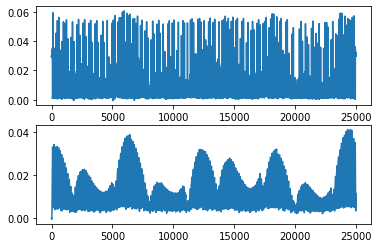

In [6]:
plt.subplot(2,1,1)
plt.plot(Normal_data['Ampl'])
plt.subplot(2,1,2)
plt.plot(normal_data_ampl_lpf)

# 2. Reshape


In [68]:
X_train = normal_data_ampl_lpf[0:24500] 
y_train = normal_data_ampl_lpf[500:25000]
X_train = np.array(X_train)*10
y_train = np.array(y_train)*10

X_train = X_train.reshape(X_train.shape[0], 1, 1).astype(np.float64)
print("Training data shapes : ", X_train.shape)

y_train = y_train.reshape(y_train.shape[0], 1, 1).astype(np.float64)
print("label data shapes : ", X_train.shape)

Training data shapes :  (24500, 1, 1)
label data shapes :  (24500, 1, 1)


# 3. Bi-LSTM Model
--> 500 시퀸스씩 입력하면 가장 비슷한 패턴을 가짐

In [17]:
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation

from keras.layers.recurrent import LSTM
from keras.layers import Input, LSTM, RepeatVector, Masking, TimeDistributed, Lambda
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K

In [75]:
TIME_STEPS = 1
input_shape = (None, TIME_STEPS , 1)  # train_size, time_steps, number_of_feature

bi_lstm_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                32,
            )
        ),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(TIME_STEPS, activation="sigmoid"),
    ]
)

bi_lstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        #tf.keras.metrics.Precision(),
        #tf.keras.metrics.Recall(),
        #tf.keras.metrics.AUC(),
    ],
)


bi_lstm_model.build(input_shape)
bi_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 1, 128)            33792     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 91,649
Trainable params: 91,649
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = bi_lstm_model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
)

Epoch 1/10
383/383 [==============================] - 2s 4ms/step - loss: 0.4143 - binary_accuracy: 0.0000e+00
Epoch 2/10
383/383 [==============================] - 1s 4ms/step - loss: 0.3901 - binary_accuracy: 0.0000e+00
Epoch 3/10
383/383 [==============================] - 2s 4ms/step - loss: 0.3899 - binary_accuracy: 0.0000e+00
Epoch 4/10
383/383 [==============================] - 1s 4ms/step - loss: 0.3899 - binary_accuracy: 0.0000e+00
Epoch 5/10
383/383 [==============================] - 1s 4ms/step - loss: 0.3899 - binary_accuracy: 0.0000e+00
Epoch 6/10
383/383 [==============================] - 1s 4ms/step - loss: 0.3899 - binary_accuracy: 0.0000e+00
Epoch 7/10
383/383 [==============================] - 2s 4ms/step - loss: 0.3898 - binary_accuracy: 0.0000e+00
Epoch 8/10
383/383 [==============================] - 1s 4ms/step - loss: 0.3899 - binary_accuracy: 0.0000e+00
Epoch 9/10
383/383 [==============================] - 1s 4ms/step - loss: 0.3900 - binary_accuracy: 0.0000e+00
E

In [29]:
yhat=bi_lstm_model.predict(X_train)

In [30]:
X_train=X_train.reshape((len(yhat)))
yhat=yhat.reshape((len(yhat)))
y_train=y_train.reshape((len(yhat)))

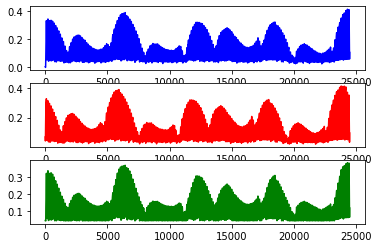

In [31]:
plt.subplot(3,1,1)
plt.plot(X_train,'b')
plt.subplot(3,1,2)
plt.plot(y_train,'r')
plt.subplot(3,1,3)
plt.plot(yhat,'g') # 예측 데이터

In [65]:
diff=np.absolute(yhat-y_train)
for i in range(len(y_train)):
    if diff[i]>y_train[i]*5:
        print(str(i)+"th"+"error")

# 4. test

In [48]:
sr_test = len(Fault_data)
fault_data_ampl=Fault_data['Ampl']
LPF_fault=signal.firwin(101, cutoff=400, fs=sr_test, pass_zero='lowpass')
fault_data_ampl_lpf=signal.lfilter(LPF_fault, [1.0], fault_data_ampl)

In [49]:
X_test = fault_data_ampl_lpf[0:24500]
y_test = fault_data_ampl_lpf[500:25000]
X_test = np.array(X_test)*10
y_test = np.array(y_test)*10

X_test = X_test.reshape(X_test.shape[0], 1, 1).astype(np.float64)
print("Training data shapes : ", X_test.shape)

y_test = y_test.reshape(y_test.shape[0], 1, 1).astype(np.float64)
print("label data shapes : ", X_test.shape)

Training data shapes :  (24500, 1, 1)
label data shapes :  (24500, 1, 1)


In [50]:
y_test_predict=bi_lstm_model.predict(X_test)

In [52]:
y_test_predict=y_test_predict.reshape((len(y_test_predict)))
y_test=y_test.reshape((len(y_test_predict)))

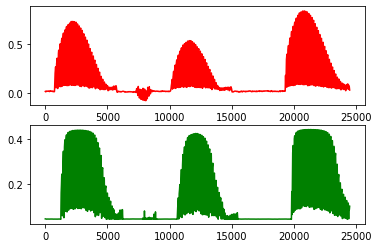

In [53]:
plt.subplot(2,1,1)
plt.plot(y_test,'r')
plt.subplot(2,1,2)
plt.plot(y_test_predict,'g') # 예측 데이터

In [63]:
diff_test=np.absolute(y_test-y_test_predict)
for i in range(len(y_test)):
    if diff_test[i]>y_test[i]*5:
        print(str(i+500)+"th sequence gets "+"error")

6269th sequence gets error
6270th sequence gets error
6271th sequence gets error
6272th sequence gets error
6273th sequence gets error
6274th sequence gets error
6275th sequence gets error
6276th sequence gets error
6277th sequence gets error
6278th sequence gets error
6279th sequence gets error
6280th sequence gets error
6281th sequence gets error
6282th sequence gets error
6283th sequence gets error
6284th sequence gets error
6285th sequence gets error
6286th sequence gets error
6287th sequence gets error
6288th sequence gets error
6289th sequence gets error
6290th sequence gets error
6291th sequence gets error
6292th sequence gets error
6293th sequence gets error
6294th sequence gets error
6491th sequence gets error
6492th sequence gets error
6493th sequence gets error
6494th sequence gets error
6495th sequence gets error
6496th sequence gets error
6497th sequence gets error
6498th sequence gets error
6499th sequence gets error
6500th sequence gets error
6501th sequence gets error
6